# LOADING

In [ ]:
import pandas as pd
import numpy as np
import glob
from IPython.display import display, clear_output
import re
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [ ]:
pd.set_option('display.max_rows', 8000)
pd.set_option('display.max_columns', 8000)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
def contains(container, elt):
  return elt in container

In [ ]:
def load_csv():
  all_files = glob.glob("PYBD/projet/data/*[0-9].pkl")
  li = []

  for filename in all_files:
      csv = pd.read_pickle(filename)
      li.append(csv)

  return pd.concat(li)

In [ ]:
  def clean_rating(df):
    df.loc[df['rating'] == 'Unrated', 'rating'] = 'Not Rated' #changing 'Unrated' movies to 'Not Rated'
    df.loc[(df['rating'] == 'E') | (df['rating'] == 'Open')| (df['rating'] == 'TV-G')| (df['rating'] == 'E10+'), 'rating'] = 'G'
    df.loc[(df['rating'] == 'MA-13') | (df['rating'] == 'TV-13')| (df['rating'] == 'TV-14'), 'rating'] = 'PG-13'
    df.loc[(df['rating'] == 'TV-Y7-FV'), 'rating'] = 'TV-Y7'
    df.loc[(df['rating'] == 'MA-17') | (df['rating'] == 'TV-MA')| (df['rating'] == 'X'), 'rating'] = 'NC-17'
    df.loc[(df['rating'] == 'TV-PG') | (df['rating'] == 'M') | (df['rating'] == 'M/PG') | (df['rating'] == 'GP'), 'rating'] = 'PG'
    df.rating.fillna('Unknown', inplace=True)
    df.loc[(df['name'] == 'Murder Manual') & (df['rating'] == '18'), 'rating'] = 'PG-13'

In [ ]:
def drop_duplicates(df):
  #We sort the movies by their amount of Nan. So in case of duplicates we keep the one with more infos.
  df = df.iloc[df.isnull().sum(axis=1).mul(-1).argsort()].drop_duplicates(subset=['name', 'released'], keep='last')
  df[df.duplicated(subset=['name', 'released'])]
  return df

In [ ]:
def clean_score(df):
  def total_score(imdb_score, rotten_score):
    if imdb_score == None or pd.isna(imdb_score):
      return rotten_score / 10
    if rotten_score == None or pd.isna(rotten_score):
      return imdb_score
    return round((imdb_score + rotten_score/10) / 2, 1)

  df.imdb_score = df.imdb_score.astype('float64')
  df.rotten_score = df.rotten_score.astype('float64')
  df['total_score'] = df.apply(lambda df: total_score(df['imdb_score'], df['rotten_score']), axis=1)

In [ ]:
def clean_suspicious_data(df):
  #Movies with big budget and low votes is really suspicious hence the drop
  tmp = df.copy()
  tmp.budget.fillna(0, inplace=True)
  tmp.gross.fillna(0, inplace=True)
  tmp['profit'] = np.abs(tmp['gross'] - tmp['budget'])
  tmp.loc[tmp['votes'] == 0, 'votes'] = 1
  ratio = tmp['profit'] / tmp['votes']
  zscore = stats.zscore(ratio)
  df.drop(df[zscore > 1].index, inplace=True)

In [ ]:
def clean_irrelevant_data(df):
  low_votes = 100 # arbitrary choice for under which we consider data may not be correct and the note may not be representative
  before = len(df)
  df.drop(df[(df['votes'] == 0)].index, inplace=True) #if no votes then it is a very very small movie and there's no critic to prove it even exists, most of them don't have a budget nor a release date
  no_votes = len(df)
  df.drop(df[df['runtime'].isna()].index, inplace=True) #We want to remove shortfilms, if we don't have length we assume it is a shortfilm.
  no_runtime = len(df)
  df.drop(df[(df['votes'] < low_votes) & df['budget'].isna()].index, inplace=True) #if there are only a few votes the note may not be representative and if we also don't have budget then there is nothing we can really do with the data
  no_budget_low_votes = len(df)
  df.drop(df[df['runtime'] < 60].index, inplace=True) #Drop short films
  no_shortfilms = len(df)
  df.drop(df[df['year'] > 2020].index, inplace=True)
  no_movies_after_2020 = len(df)
  print("IRRELEVANT DATA:")
  print(str(before - no_votes) + " movies with no vote")
  print(str(no_votes - no_runtime) + " movies with no runtime")
  print(str(no_runtime - no_budget_low_votes) + " movies with no budget and low votes")
  print(str(no_budget_low_votes - no_shortfilms) + " shortfilms")
  print(str(no_shortfilms - no_movies_after_2020) + " removed movie released after 2020")
  print()

In [ ]:
def clean_genre(df_):
  return df_[df_.apply(lambda df: not contains(df['genre'], 'Talk-Show')
                              and not contains(df['genre'], 'Reality-TV')
                              and not contains(df['genre'], 'News')
                              and not contains(df['genre'], 'Game-Show'), axis=1)]

In [ ]:
def pre_treatment(df):
  before = len(df)
  df.reset_index(inplace=True, drop=True)

  clean_rating(df)
  df = drop_duplicates(df)

  #DIRECTOR IS WRITER
  def director_is_writer(directors, writers):
    if directors == None or writers == None:
      return 0
    for director in directors:
      for writer in writers:
        if director in writer:
          return 1
    return 0

  df['director_is_writer'] = df.apply(lambda df: director_is_writer(df['director'], df['writer']), axis=1)

  #PROFIT
  df.budget = df.budget.astype('float64')
  df.gross = df.gross.astype('float64')
  df['profit'] = df['gross'] - df['budget']

  clean_score(df)

  #OTHER
  df.runtime = df.runtime.astype('float64')
  df.votes = df.votes.astype('float64')
  df.votes.fillna(0, inplace=True)
  df.company = df.company.apply(lambda d: d if isinstance(d, list) else [])
  df.writer = df.writer.apply(lambda d: d if isinstance(d, list) else [])
  df.genre = df.genre.apply(lambda d: d if isinstance(d, list) else [])

  df.released = pd.to_datetime(df.released)
  df.loc[~df.released.isna(), 'year'] = df.released.dt.year

  removed_dup = len(df)

  df = clean_genre(df)
  clean_irrelevant_data(df)
  clean_irrelevant = len(df)

  clean_suspicious_data(df)
  clean_suspicious = len(df)

  print("SUMMARY:")
  print("Length of Dataset:")
  print("BEFORE: " + str(before))
  print("Removed duplicated: " + str(before - removed_dup))
  print("Removed Irrelevant: " + str(removed_dup - clean_irrelevant))
  print("Removed Suspicious: " + str(clean_irrelevant - clean_suspicious))
  print("AFTER: " + str(clean_suspicious))

  return df

# Core

In [ ]:
movies = load_csv()
print(len(movies))

69733


In [ ]:
movies = pre_treatment(movies)

IRRELEVANT DATA:
20241 movies with no vote
3739 movies with no runtime
11038 movies with no budget and low votes
626 shortfilms
367 removed movie released after 2020

SUMMARY:
Length of Dataset:
BEFORE: 69733
Removed duplicated: 184
Removed Irrelevant: 36174
Removed Suspicious: 310
AFTER: 33065


Une fois le pré-traitement fini on se retrouve avec beaucoup moins de film certes. Mais ce projet nous a fait réaliser qu'il y a énormément de film qui sortent chaque dont la plupart sont produit avec de tout petits budget si bien que très peu de gens les connaisse. On peut estimer qu'au delà des 100 films à plus gros budget/votes chaque année on peut dire que les films ont un poids très négligable sur l'industrie individuellement.
Il manque très souvent beaucoup de données pour ces petits films c'est pourquoi nous en avons supprimer une grande partie.
D'un autre côté, les studios peuvent ne pas publier le budget et la recette de leur films comme Netflix. Ces films importants ne doivent pas être supprimé, on peut les reconnaître à un très grand nombre de votes.

In [ ]:
movies.isna().sum()

name                      0
rating                    0
genre                     0
released                929
year                      0
imdb_score                0
rotten_score          31216
votes                     0
director                  0
writer                    0
star                      0
country                   0
budget                15624
gross                 21550
company                   0
runtime                   0
director_is_writer        0
profit                25786
total_score               0
dtype: int64

On peut voir que sur les 24000 films qui nous reste, 16000 d'entre eux n'ont pas soit le budget soit la recette. C'est problématique mais les supprimer réduirait trop notre dataset. Selon nos besoin nous les supprimerons pour certaines actions.
De même pour le rotten_score, il y a beaucoup moins de film sur rotten_tomatoes mais nous avons la note imdb à côté. Pour les films plus connu il y a bien le score rotten.
Enfin le taux d'absence de date de sortie est assez faible et en vérifiant il s'agit de véritable film qui ont bien été visionné étant donné que nous avons supprimer les films avec moins de 100 votes.

In [ ]:
movies.sort_values(by='profit', ascending=True).head(5)

,name,rating,genre,released,year,imdb_score,rotten_score,votes,director,writer,star,country,budget,gross,company,runtime,director_is_writer,profit,total_score
62741,The Irishman,R,"[Biography, Crime, Drama]",2019-11-27,2019,7.80,NaN,"369,000.00",[Martin Scorsese],[Steven Zaillian],"[Robert De Niro, Al Pacino, Joe Pesci, Harvey ...",[United States],"159,000,000.00","968,853.00","[Tribeca Productions, Sikelia Productions, Win...",209.00,0,"-158,031,147.00",7.80
66159,Mulan,PG-13,"[Action, Adventure, Drama, Fantasy]",2020-09-04,2020,5.70,47.00,"143,000.00",[Niki Caro],"[Rick Jaffa, Amanda Silver, Lauren Hynek]","[Liu Yifei, Donnie Yen, Gong Li, Jet Li, Jason...","[United States, China]","200,000,000.00","66,800,000.00","[Walt Disney Pictures, Jason T. Reed Productio...",115.00,0,"-133,200,000.00",5.20
32618,Mars Needs Moms,PG,"[Animation, Action, Adventure, Family, Sci-Fi]",2011-03-11,2011,5.40,NaN,"22,000.00",[Simon Wells],[Simon Wells],"[Seth Green, Joan Cusack, Dan Fogler, Elisabet...",[United States],"150,000,000.00","39,233,678.00","[Walt Disney Pictures, ImageMovers Digital, Fo...",88.00,1,"-110,766,322.00",5.40
15046,The 13th Warrior,R,"[Action, Adventure, History]",1999-08-27,1999,6.60,66.00,"123,000.00","[John McTiernan, Michael Crichton]",[Michael Crichton],"[Antonio Banderas, Diane Venora, Dennis Storhø...",[United States],"160,000,000.00","61,698,899.00",[Touchstone Pictures],102.00,1,"-98,301,101.00",6.60
18819,The Adventures of Pluto Nash,PG-13,"[Action, Comedy, Sci-Fi]",2002-08-16,2002,3.80,NaN,"26,000.00",[Ron Underwood],[Neil Cuthbert],"[Eddie Murphy, Jay Mohr, Randy Quaid, Rosario ...","[United States, Australia]","100,000,000.00","7,103,973.00","[Castle Rock Entertainment, Village Roadshow P...",95.00,0,"-92,896,027.00",3.80


Voyons les 5 films qui ont fait les plus gros flop du dataset. Le premier serait Irishman, en réalité le film est sortie alors que les cinéma étaient fermés, il est d'ailleurs un des seul film à être sortie au cinéma à cette période. En revanche il est aussi sortie sur Netflix qui ne communique pas ses chiffres. The Irishman ayant été ouvertement un succès il ne constitue en réalité pas du tout un flop, il nous manque seulement les données de Netflix.

Même chose pour Mulan qui est sortie sur Disney+ en même temps qu'au cinéma ou presque en plein COVID.

Les 3 suivants en revanche constituent bel et bien des flops.

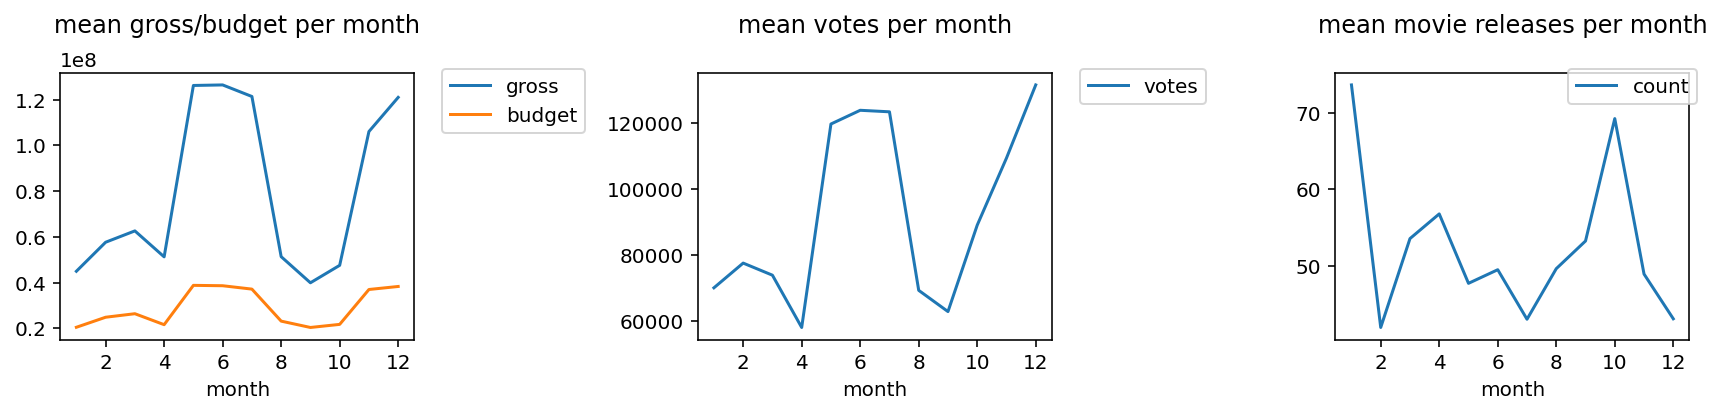

In [ ]:
#Profit en fonction des dates de sortie de films en 2019
df = movies.dropna(subset=['released', 'profit']).sort_values(by='released')
df_mayno_profit = movies.dropna(subset=['released']).sort_values(by='released')
df_mean = df.groupby(by=[df.released.dt.month]).mean()
df_count = df.groupby(by=[df.released.dt.month]).count().drop(columns=['released'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

axes[0].plot('released', 'gross', data=df_mean.reset_index(), label="gross")
axes[0].plot('released', 'budget', data=df_mean.reset_index(), label="budget")
axes[0].set_xlabel('month')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_title('mean gross/budget per month', pad=20)
axes[0].legend(bbox_to_anchor = (1.05, 1.05))

axes[1].plot('released', 'votes', data=df_mean.reset_index(), label="votes")
axes[1].set_xlabel('month')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_title('mean votes per month', pad=20)
axes[1].legend(bbox_to_anchor = (1.05, 1.05))

movie_mean = df_mayno_profit.groupby(by=[df_mayno_profit.released.dt.month]).count() / len(df_mayno_profit.year.unique())
axes[2].plot('released', 'name', data=movie_mean.drop(columns=['released']).reset_index(), label="count")
axes[2].set_xlabel('month')
axes[2].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[2].set_title('mean movie releases per month', pad=20)
axes[2].legend(bbox_to_anchor = (1.05, 1.05))

fig.tight_layout()

On voit ici le succès des films en fonction du mois de sortie. On peut voir que qu'entre mai et aout se trouve les sorties du films à plus gros budget et que les recettes sont les plus élevés. Cela est cohérent avec le nombre de vote qui augmente puisque plus il y a du monde qui va le film et plus il sera susceptible d'avoir de vote.

En revanche on remarque que la quantité moyenne de film sortie chaque mois est très différentes des revenues/votes. Pire que cela, les courbes semblent complétement inversée. Lorsque des films à gros budget sortent, il y a peu de sortie de film. Cela peut s'expliquer par une volonté des films à petit budget de ne pas sortir en même temps que les gros budgets pour éviter de passer inaperçu. C'est un moyen d'éviter la concurrence.

In [ ]:
df = movies.dropna(subset=['profit'])
zscore = np.abs(stats.zscore(df.profit))
df[zscore > 3]

,name,rating,genre,released,year,imdb_score,rotten_score,votes,director,writer,star,country,budget,gross,company,runtime,director_is_writer,profit,total_score
35173,Pirates of the Caribbean: On Stranger Tides,PG-13,"[Action, Adventure, Fantasy]",2011-05-20,2011,6.60,NaN,"511,000.00",[Rob Marshall],"[Ted Elliott, Terry Rossio, Stuart Beattie]","[Johnny Depp, Penélope Cruz, Ian McShane, Geof...","[United States, United Kingdom]","250,000,000.00","1,045,713,802.00","[Walt Disney Pictures, Jerry Bruckheimer Films...",136.00,0,"795,713,802.00",6.60
41238,Thor: The Dark World,PG-13,"[Action, Adventure, Fantasy]",2013-11-08,2013,6.80,NaN,"654,000.00",[Alan Taylor],"[Christopher L. Yost, Christopher Markus, Step...","[Chris Hemsworth, Natalie Portman, Tom Hiddles...",[United States],"170,000,000.00","644,783,140.00","[Marvel Studios, Walt Disney Pictures]",112.00,0,"474,783,140.00",6.80
41237,Gravity,PG-13,"[Action, Drama, Sci-Fi, Thriller]",2013-10-04,2013,7.70,NaN,"809,000.00",[Alfonso Cuarón],[Alfonso Cuarón],"[Sandra Bullock, George Clooney, Ed Harris, Or...","[United Kingdom, United States]","100,000,000.00","723,192,705.00","[Warner Bros., Esperanto Filmoj, Heyday Films]",91.00,1,"623,192,705.00",7.70
41221,Iron Man 3,PG-13,"[Action, Adventure, Sci-Fi]",2013-05-03,2013,7.20,NaN,"820,000.00",[Shane Black],"[Drew Pearce, Shane Black, Stan Lee]","[Robert Downey Jr., Guy Pearce, Gwyneth Paltro...",[United States],"200,000,000.00","1,214,811,252.00","[Marvel Studios, Paramount Pictures, DMG Enter...",130.00,1,"1,014,811,252.00",7.20
41219,Frozen,PG,"[Animation, Adventure, Comedy, Family, Fantasy...",2013-11-27,2013,7.50,NaN,"609,000.00","[Chris Buck, Jennifer Lee]","[Jennifer Lee, Hans Christian Andersen, Chris ...","[Kristen Bell, Idina Menzel, Jonathan Groff, J...",[United States],"150,000,000.00","1,281,508,100.00","[Walt Disney Animation Studios, Walt Disney Pi...",102.00,1,"1,131,508,100.00",7.50
41218,The Hunger Games: Catching Fire,PG-13,"[Action, Adventure, Drama, Sci-Fi, Thriller]",2013-11-22,2013,7.50,NaN,"649,000.00",[Francis Lawrence],[Simon Beaufoy],"[Jennifer Lawrence, Josh Hutcherson, Liam Hems...",[United States],"130,000,000.00","865,011,746.00","[Color Force, Lionsgate]",146.00,0,"735,011,746.00",7.50
41229,The Hobbit: The Desolation of Smaug,PG-13,"[Adventure, Fantasy]",2013-12-13,2013,7.80,NaN,"640,000.00",[Peter Jackson],"[Fran Walsh, Philippa Boyens, Peter Jackson]","[Ian McKellen, Martin Freeman, Richard Armitag...","[New Zealand, United States]","225,000,000.00","959,027,992.00","[Metro-Goldwyn-Mayer (MGM), New Line Cinema, W...",161.00,1,"734,027,992.00",7.80
35194,Mission: Impossible - Ghost Protocol,PG-13,"[Action, Adventure, Thriller]",2011-12-21,2011,7.40,NaN,"479,000.00",[Brad Bird],[Bruce Geller],"[Tom Cruise, Jeremy Renner, Simon Pegg, Paula ...",[United States],"145,000,000.00","694,713,380.00","[Paramount Pictures, Skydance Media, TC Produc...",132.00,0,"549,713,380.00",7.40
10093,The Lion King,G,"[Animation, Adventure, Drama, Family, Musical]",1994-06-24,1994,8.50,NaN,"1,000,000.00","[Roger Allers, Rob Minkoff]","[Irene Mecchi, Jonathan Roberts, Linda Woolver...","[Matthew Broderick, Jeremy Irons, James Earl J...",[United States],"45,000,000.00","1,063,611,805.00","[Walt Disney Pictures, Walt Disney Animation S...",88.00,0,"1,018,611,805.00",8.50
10091,Forrest Gump,PG-13,"[Drama, Romance]",1994-07-06,1994,8.80,NaN,"2,000,000.00",[Robert Zemeckis],[Winston Groom],"[Tom Hanks, Robin Wright, Gary Sinise, Sally F...",[United States],"55,000,000.00","678,226,133.00","[Paramount Pictures, The Steve Tisch Company, ...",142.00,0,"623,226,133.00",8.80


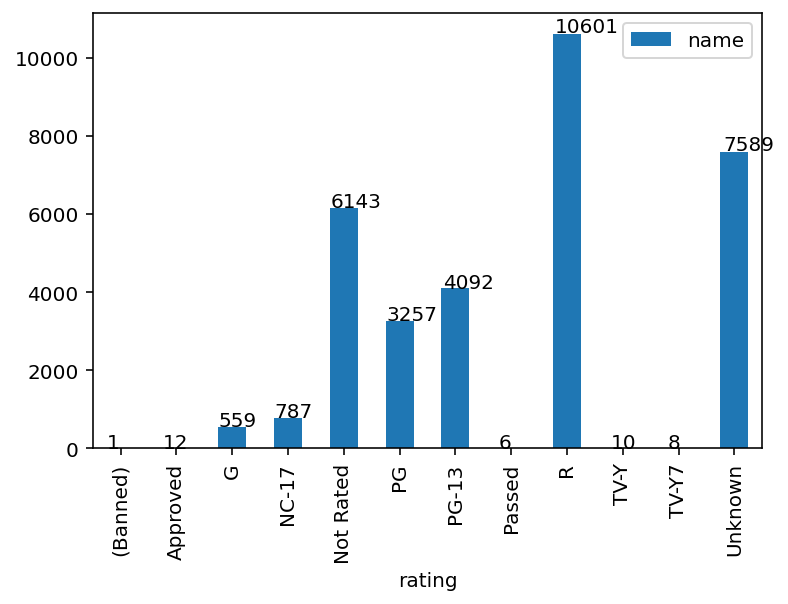

In [ ]:
df = movies.dropna(subset=['rating'])
df = df.groupby('rating').count()
ax = df.plot(y='name', kind='bar')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Score

<AxesSubplot:xlabel='budget'>

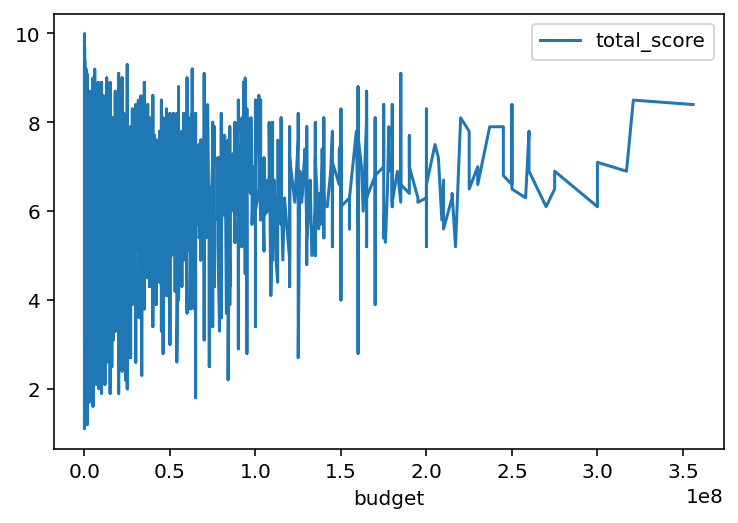

In [ ]:
df = movies.dropna(subset=['budget','total_score']).sort_values(by='budget')
df.plot(x='budget', y='total_score')

Ce graphique représentant la note moyenne des films en fonction du budget nous montre plusieurs chose.
Tout d'abord, il semblerait que plus le budget est élevé, mieux ils sont reçu, en effet on ne trouve que très peu de film très mal noté à mesure que le budget augmente. En revanche les notes les plus élevés n'ont pas vraiment l'air de changer.
Ce graphique étant très compact, il nous faudra représenter ses donner autrement pour en savoir plus.

In [ ]:
max_budget = movies.dropna(subset=['budget'])['budget'].max()
df = movies.dropna(subset=['budget'])
group_by_budget = df.groupby(pd.cut(df["budget"], np.geomspace(1, max_budget, 10)))

<AxesSubplot:xlabel='budget'>

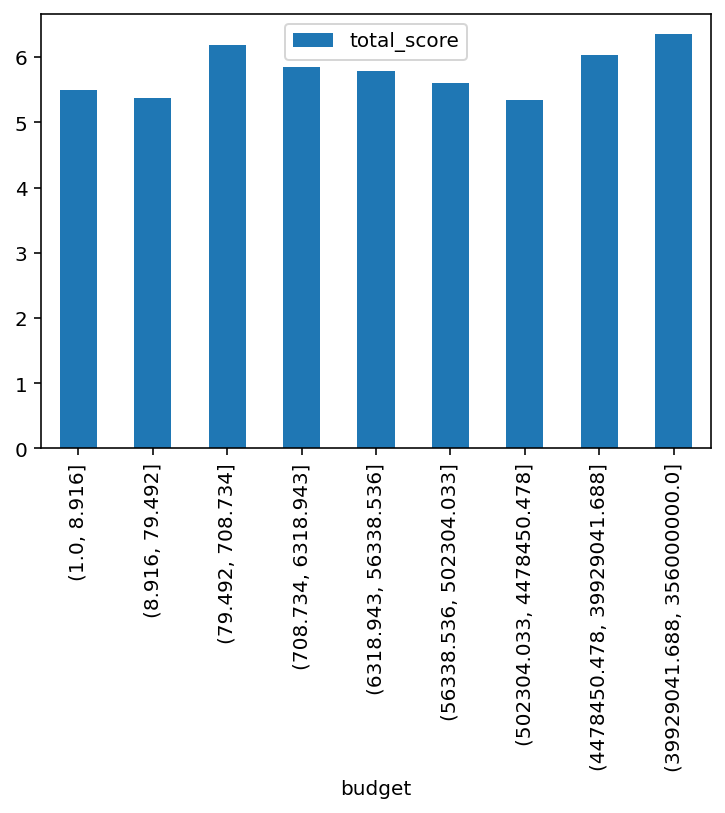

In [ ]:
group_by_budget.mean().plot(y='total_score', kind='bar') #Note moyenne en fonction du budget

Nous voyons ici le score moyen des film en fonction des tranches de budget et il semblerait bien qu'en moyenne le budget n'influe que très peu sur la moyenne des notes. Pourtant dans le schéma précédent il y avait une différence nette en terme de notation. Essayons de regarder l'ecart-type.

<AxesSubplot:xlabel='budget'>

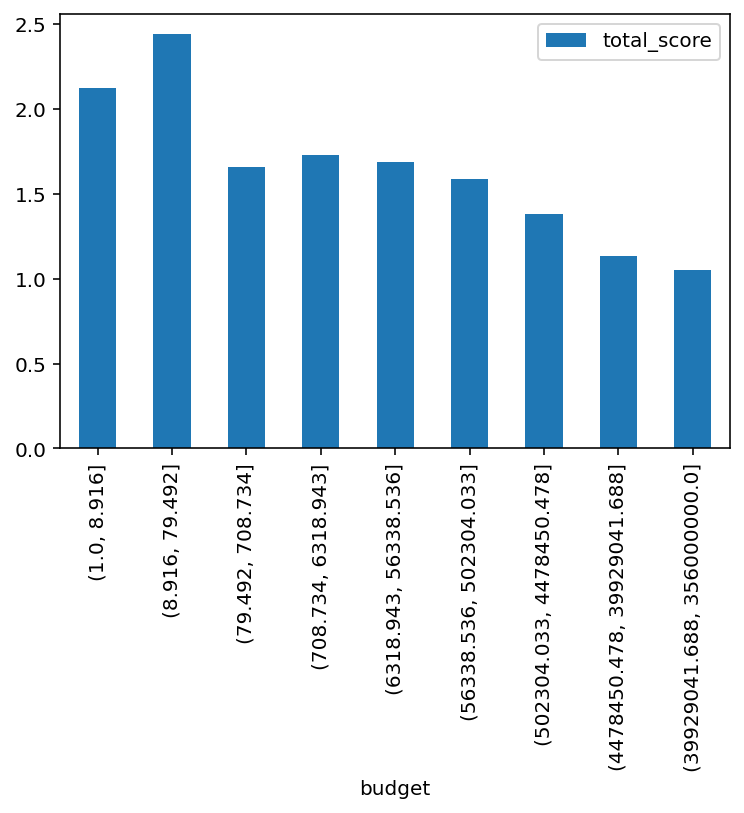

In [ ]:
group_by_budget.std().plot(y='total_score', kind='bar')

On comprend grâce à ce graphique représentant l'écart-type des notes en fonction des tranches de budget que celui-ci se réduit. On peut en déduire que plus le budget est élevé et moins il y a d'écart entre le note des films.

Cela peut s'expliquer par plusieurs facteurs: le premier est que si un studio confie un gros budget, il aura tendance à choisir une équipe expérimenté et qualifié, qui ont fait leur preuve. De plus il y a beaucoup de vérification avant qu'un film sorte pour assuré un certain niveau de "qualité" et éventuellement retourner certaines scène. Ces phases de vérification réduisent drastiquement les chances d'avoir un film réellement très mauvais.
Sur les petits budget, l'équipe est en général moins qualifié et/ou expérimenté voire amateur et plus petite ce qui implique que certaines personnes exerce plusieurs tâche différentes alors qu'avec des budgets élevé les tâches sont effectué par des spécialistes dont c'est le métier.

On peut d'ailleurs vérifier en partant cette dernière remarque en regardant le nombre de film pour lesquel le réalisateur a participé à l'écriture du film.

<AxesSubplot:xlabel='budget'>

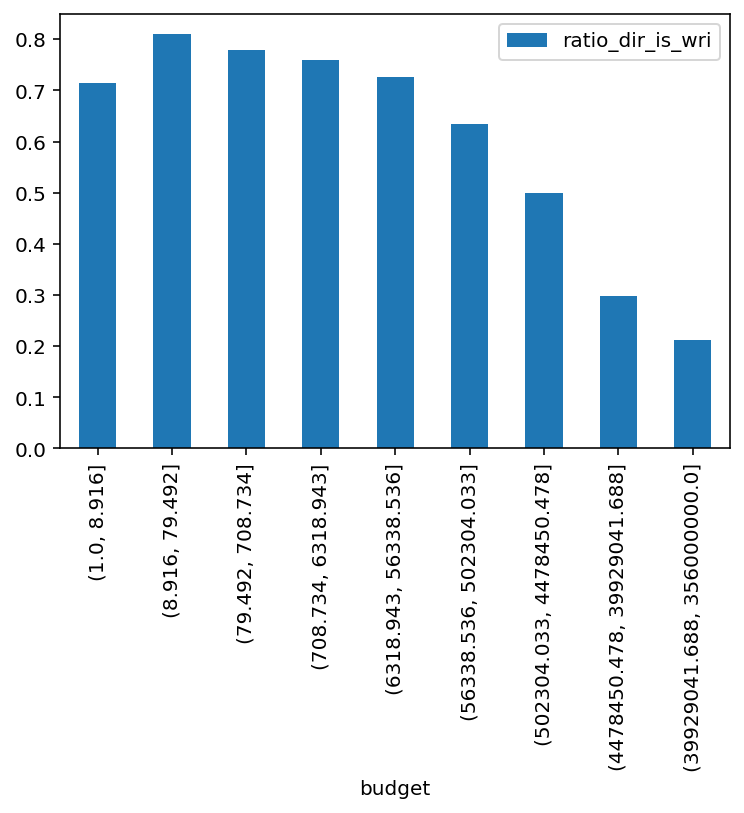

In [ ]:
sum = group_by_budget.sum()
sum['ratio_dir_is_wri'] = sum.director_is_writer / group_by_budget.count().name
sum.plot(y='ratio_dir_is_wri', kind='bar')

En effet on voit que la proportion de réalisateur qui a participé à l'écriture tend à baisser sur les films à gros budget. Les qualités pour être un bon scénariste ne sont pas du tout les même que pour être un bon réalisateur.

<AxesSubplot:xlabel='budget'>

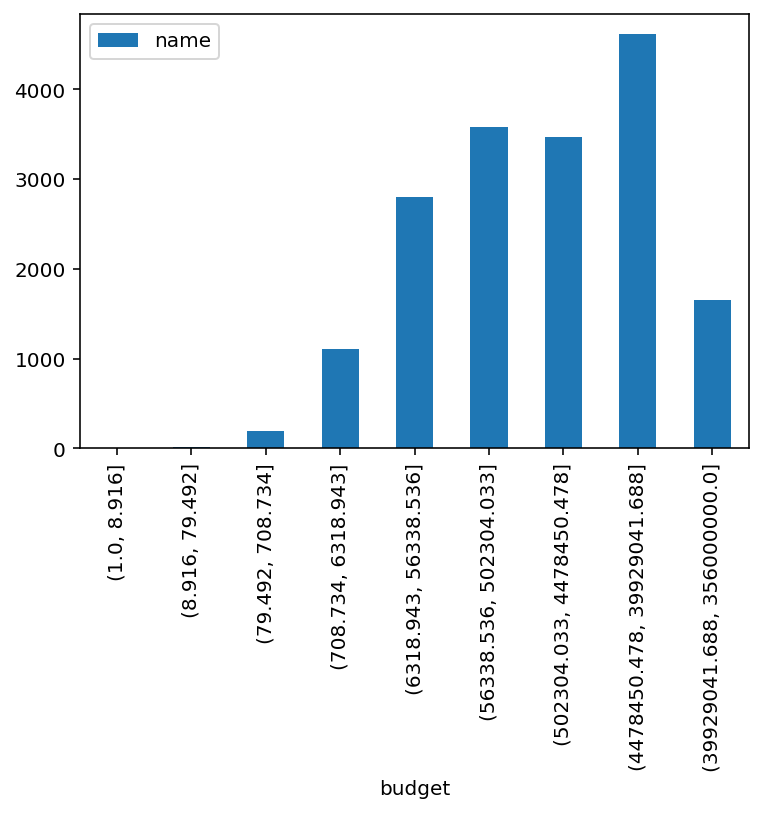

In [ ]:
group_by_budget.count().plot(y='name', kind='bar') #Nombre de films en fonction du budget

On voit ici la quantité de film en fonction des budgets et on voit que la plupart des films ont un budget compris entre 6000 et 39 000 000 de dollars. Au delà il s'agit de budget de blockbuster qui sont moins nombreux et en dessous de 700 dollars il est très difficile de réaliser un film de qualité et d'en faire la publicité pour qu'il soit référencé sur des sites comme IMDB. Le pré traitement effectué a aussi supprimé beaucoup de ces films à tout petit budget.

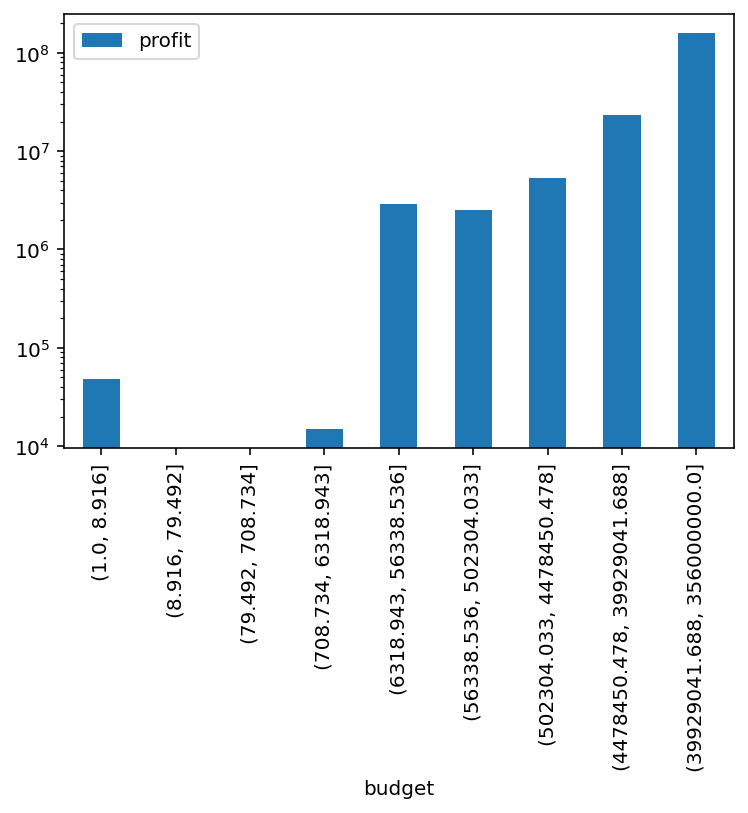

In [ ]:
group_by_budget.mean().plot(y='profit', kind='bar').set_yscale('log') #profit à échelle logarithmique en fonction du budget

Cette histogramme représente le profit moyen en fonction du budget avec une échelle logarithmique. Sans surprise plus le budget est élevé et plus les films rapportent en moyenne.

On peut noter aussi un nombre assez élevé de film entre 1$ et 9$. En effet, il s'agit de budget tout à fait accessible pour les particuliers.

# Genre

In [ ]:
df = movies[movies.genre.apply(lambda df: len(df) != 0 )]
group_by_genre = df.explode("genre").groupby("genre").mean()
group_by_genre['count'] = df.explode("genre").groupby("genre").size()
group_by_genre.drop(columns=['year'])

,imdb_score,rotten_score,votes,budget,gross,runtime,director_is_writer,profit,total_score,count
genre,,,,,,,,,,
Action,5.20,44.56,"48,073.89","29,069,627.99","114,579,280.43",97.95,0.38,"90,735,585.93",5.17,5660
Adventure,5.55,53.16,"73,260.20","48,071,957.64","174,898,778.44",99.34,0.36,"150,924,074.05",5.54,3027
Animation,6.04,63.41,"59,350.40","53,705,358.21","166,085,101.61",87.32,0.39,"166,196,736.84",6.04,743
Biography,6.59,71.21,"55,177.99","21,216,386.35","38,847,793.97",112.17,0.34,"27,910,043.65",6.60,862
Comedy,5.64,54.56,"20,822.36","13,783,220.05","48,938,861.80",94.01,0.49,"46,701,906.50",5.63,11162
Crime,5.67,49.35,"34,601.97","15,342,270.82","41,580,802.48",98.89,0.42,"30,822,523.96",5.65,4391
Drama,5.91,57.62,"22,577.43","10,997,756.24","31,980,473.51",99.15,0.50,"29,071,321.76",5.90,16015
Family,5.68,51.98,"35,511.28","36,380,673.28","124,719,460.35",93.41,0.33,"114,890,551.41",5.67,2096
Fantasy,5.49,55.67,"54,060.26","36,955,061.50","129,882,232.42",96.50,0.44,"109,350,070.54",5.48,2193


Voici une moyenne des données de selon les genres.

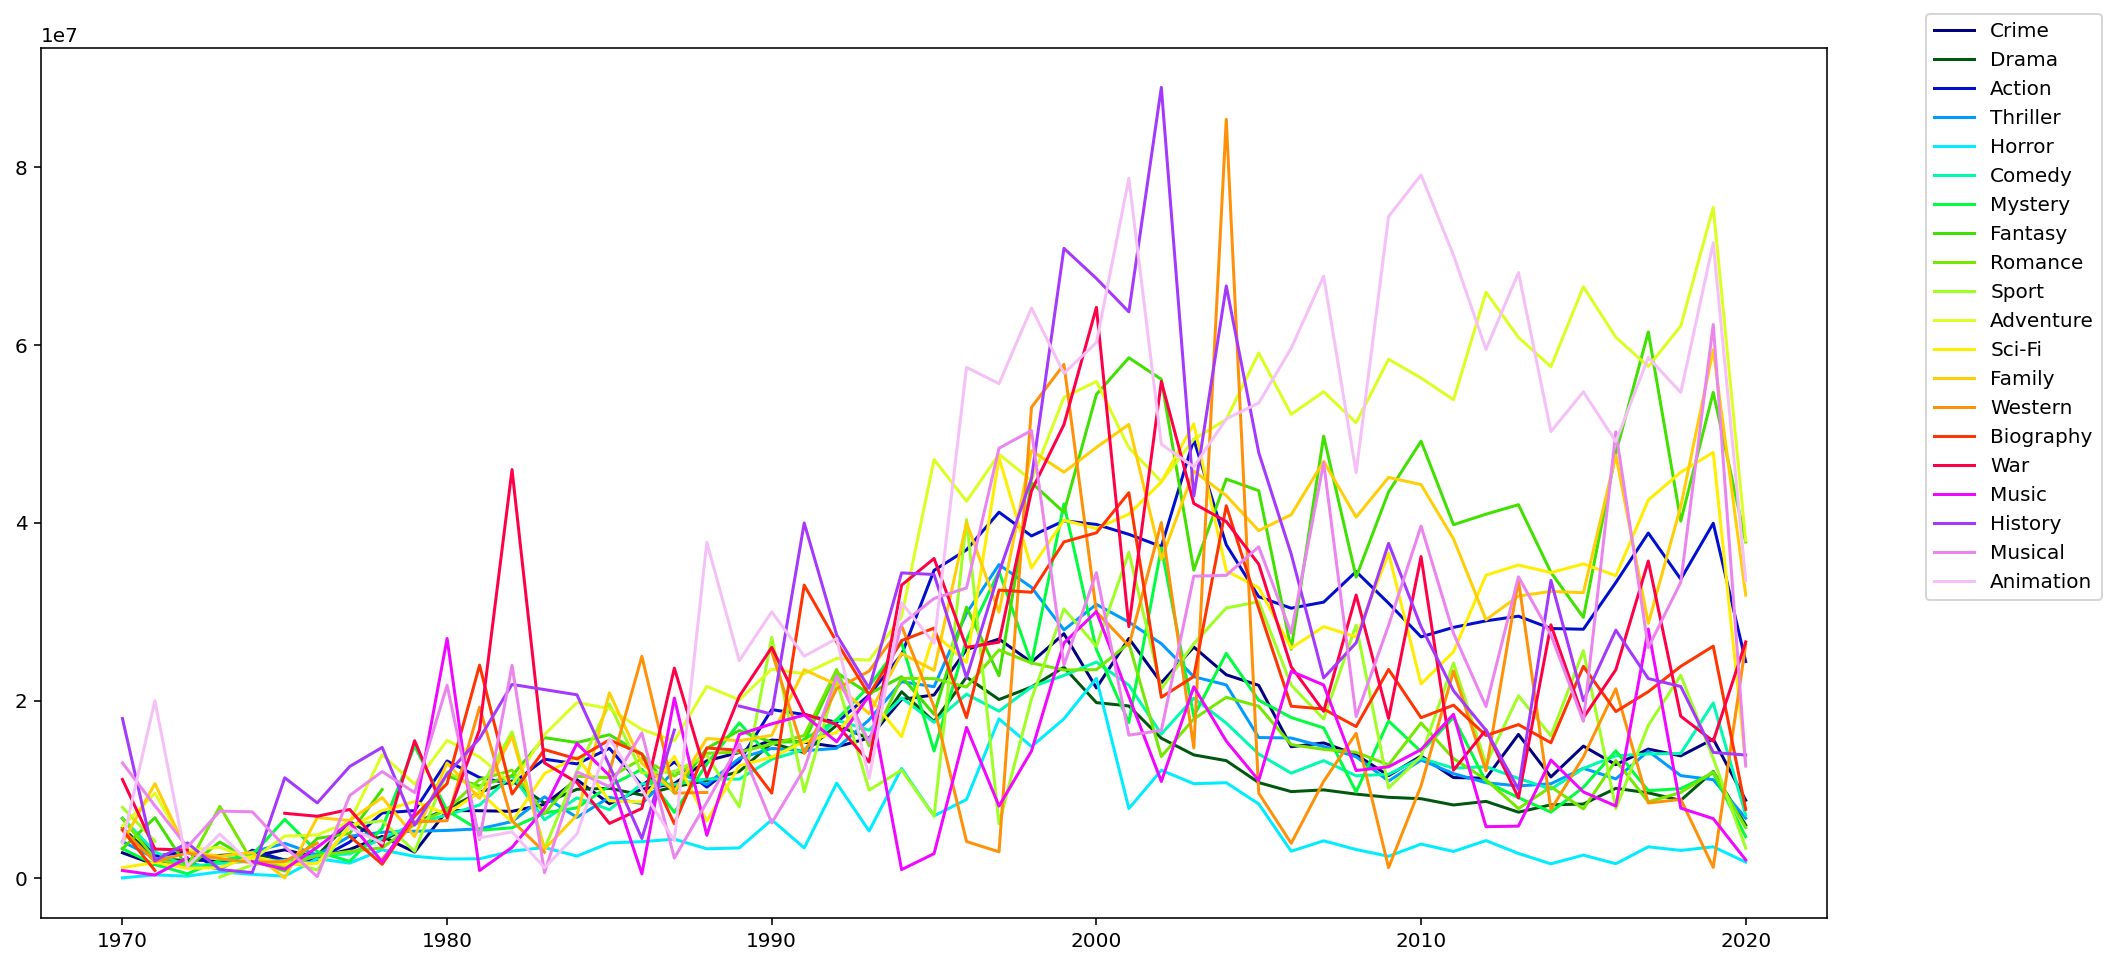

In [ ]:
def getColor(c, N, idx):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap(c)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

df = movies[movies.genre.apply(lambda df: len(df) != 0 )]
df = df.explode("genre").sort_values('released')
plt.figure(figsize=(16,8))
genres = df.genre.unique()
i = 0
for genre in genres:
  _df = df[df['genre'] == genre]
  _df = _df.groupby('year').mean()
  plt.plot('year', 'budget', data=_df.reset_index(), label=genre, color=getColor("gist_ncar", len(genres) + 1, i))
  i += 1

plt.legend(bbox_to_anchor = (1.05, 1.05))
plt.show()

In [ ]:
df = movies[movies.genre.apply(lambda df: len(df) != 0 )]
df = df.explode("genre").sort_values('released')
test = df.groupby(["year", "genre"])

<AxesSubplot:xlabel='genre'>

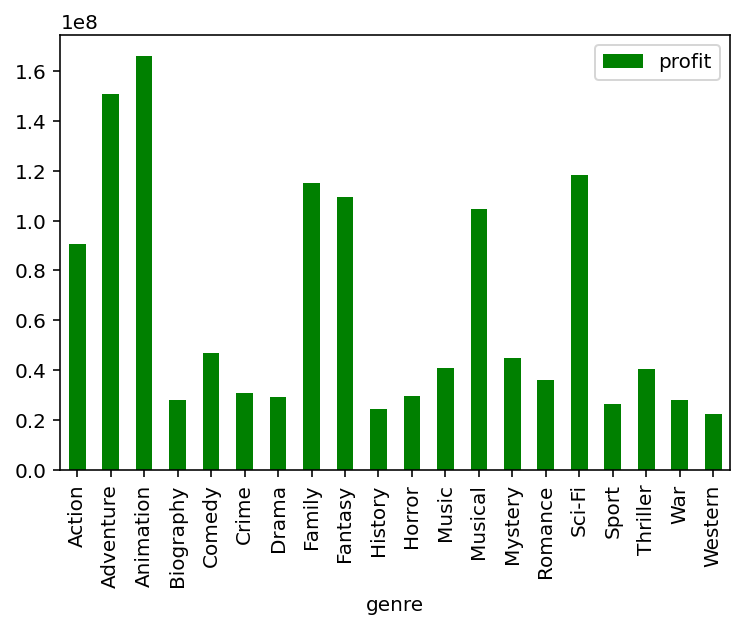

In [ ]:
group_by_genre['positive'] = group_by_genre['profit'] >= 0
group_by_genre.plot(y='profit', kind='bar', color=group_by_genre.positive.map({True: 'g', False: 'r'}))

On voit ici le profit moyen selon les genres. On remarque les plus rentables sont les films d'Aventure, d'Animation.

On constate que ce sont des genres souvent assez grand public cela peut expliquer leur succès, les familles vont au cinéma ensemble.

In [ ]:
df = movies.drop(columns=['year'])
group_by_year = df.groupby(df.released.dt.year).mean()
group_by_year['count'] = df.groupby(df.released.dt.year).size()
group_by_year

,imdb_score,rotten_score,votes,budget,gross,runtime,director_is_writer,profit,total_score,count
released,,,,,,,,,,
"1,970.00",5.67,NaN,"5,330.34","4,728,447.25","29,855,568.44",100.82,0.24,"28,252,072.86",5.67,160
"1,971.00",5.67,NaN,"6,880.44","2,386,912.76","9,310,282.89",97.05,0.31,"8,966,356.53",5.67,197
"1,972.00",5.66,NaN,"16,170.25","1,632,281.81","35,493,758.69",95.38,0.27,"42,543,963.80",5.66,219
"1,973.00",5.73,NaN,"9,547.31","2,007,016.66","49,143,388.32",96.67,0.28,"54,334,506.80",5.73,224
"1,974.00",5.69,NaN,"13,361.51","2,318,881.18","33,766,554.71",95.93,0.30,"31,194,510.89",5.69,209
"1,975.00",5.63,NaN,"13,656.28","2,273,209.01","41,260,842.81",97.46,0.29,"44,391,056.10",5.63,207
"1,976.00",5.60,NaN,"13,759.83","2,711,847.04","29,554,406.76",98.64,0.27,"35,093,172.06",5.60,200
"1,977.00",5.61,NaN,"14,331.71","4,347,382.81","66,116,725.28",98.27,0.27,"105,933,937.31",5.61,182
"1,978.00",5.71,NaN,"9,873.81","5,172,882.35","34,360,266.02",99.61,0.34,"40,502,082.38",5.71,203


Voici une moyenne de nos données en fonction des années.

On peut voir que l'année 2020 constitue une anomalie en terme de chiffre, bien sûr on peut l'expliquer avec le COVID qui a empêché les cinéma d'être ouvert. Alors même que e nombre de film sortie est le même.

# Dash

In [ ]:
%%writefile /tmp/helper.py

import pandas as pd
import numpy as np
import glob
#from IPython.display import display, clear_output
#import re
from scipy import stats

def contains(container, elt):
  return elt in container

def load_csv():
  all_files = glob.glob("PYBD/projet/data/*[0-9].pkl")
  li = []

  for filename in all_files:
      csv = pd.read_pickle(filename)
      li.append(csv)

  return pd.concat(li)

def clean_rating(df):
    df.loc[df['rating'] == 'Unrated', 'rating'] = 'Not Rated' #changing 'Unrated' movies to 'Not Rated'
    df.loc[(df['rating'] == 'E') | (df['rating'] == 'Open')| (df['rating'] == 'TV-G')| (df['rating'] == 'E10+'), 'rating'] = 'G'
    df.loc[(df['rating'] == 'MA-13') | (df['rating'] == 'TV-13')| (df['rating'] == 'TV-14'), 'rating'] = 'PG-13'
    df.loc[(df['rating'] == 'TV-Y7-FV'), 'rating'] = 'TV-Y7'
    df.loc[(df['rating'] == 'MA-17') | (df['rating'] == 'TV-MA')| (df['rating'] == 'X'), 'rating'] = 'NC-17'
    df.loc[(df['rating'] == 'TV-PG') | (df['rating'] == 'M') | (df['rating'] == 'M/PG') | (df['rating'] == 'GP'), 'rating'] = 'PG'
    df.rating.fillna('Unknown', inplace=True)
    df.loc[(df['name'] == 'Murder Manual') & (df['rating'] == '18'), 'rating'] = 'PG-13'

def drop_duplicates(df):
  #We sort the movies by their amount of Nan. So in case of duplicates we keep the one with more infos.
  df = df.iloc[df.isnull().sum(axis=1).mul(-1).argsort()].drop_duplicates(subset=['name', 'released'], keep='last')
  df[df.duplicated(subset=['name', 'released'])]
  return df

def clean_score(df):
  def total_score(imdb_score, rotten_score):
    if imdb_score == None or pd.isna(imdb_score):
      return rotten_score / 10
    if rotten_score == None or pd.isna(rotten_score):
      return imdb_score
    return round((imdb_score + rotten_score/10) / 2, 1)

  df.imdb_score = df.imdb_score.astype('float64')
  df.rotten_score = df.rotten_score.astype('float64')
  df['total_score'] = df.apply(lambda df: total_score(df['imdb_score'], df['rotten_score']), axis=1)

def clean_suspicious_data(df):
  #Movies with big budget and low votes is really suspicious hence the drop
  tmp = df.copy()
  tmp.budget.fillna(0, inplace=True)
  tmp.gross.fillna(0, inplace=True)
  tmp['profit'] = np.abs(tmp['gross'] - tmp['budget'])
  tmp.loc[tmp['votes'] == 0, 'votes'] = 1
  ratio = tmp['profit'] / tmp['votes']
  zscore = stats.zscore(ratio)
  df.drop(df[zscore > 1].index, inplace=True)

def clean_irrelevant_data(df):
  low_votes = 100 # arbitrary choice for under which we consider data may not be correct and the note may not be representative
  before = len(df)
  df.drop(df[(df['votes'] == 0)].index, inplace=True) #if no votes then it is a very very small movie and there's no critic to prove it even exists, most of them don't have a budget nor a release date
  no_votes = len(df)
  df.drop(df[df['runtime'].isna()].index, inplace=True) #We want to remove shortfilms, if we don't have length we assume it is a shortfilm.
  no_runtime = len(df)
  df.drop(df[(df['votes'] < low_votes) & df['budget'].isna()].index, inplace=True) #if there are only a few votes the note may not be representative and if we also don't have budget then there is nothing we can really do with the data
  no_budget_low_votes = len(df)
  df.drop(df[df['runtime'] < 60].index, inplace=True) #Drop short films
  no_shortfilms = len(df)
  df.drop(df[df['year'] > 2020].index, inplace=True)
  no_movies_after_2020 = len(df)
  df.drop(df.genre[df.genre.apply(lambda x: len(x) == 0)].index, inplace=True)

def clean_genre(df_):
  return df_[df_.apply(lambda df: not contains(df['genre'], 'Talk-Show')
                              and not contains(df['genre'], 'Reality-TV')
                              and not contains(df['genre'], 'News')
                              and not contains(df['genre'], 'Game-Show'), axis=1)]

def pre_treatment(df):
  before = len(df)
  df.reset_index(inplace=True, drop=True)

  clean_rating(df)
  df = drop_duplicates(df)

  #DIRECTOR IS WRITER
  def director_is_writer(directors, writers):
    if directors == None or writers == None:
      return 0
    for director in directors:
      for writer in writers:
        if director in writer:
          return 1
    return 0

  df['director_is_writer'] = df.apply(lambda df: director_is_writer(df['director'], df['writer']), axis=1)

  #PROFIT
  df.budget = df.budget.astype('float64')
  df.gross = df.gross.astype('float64')
  df['profit'] = df['gross'] - df['budget']

  clean_score(df)

  #OTHER
  df.runtime = df.runtime.astype('float64')
  df.votes = df.votes.astype('float64')
  df.votes.fillna(0, inplace=True)
  df.company = df.company.apply(lambda d: d if isinstance(d, list) else [])
  df.writer = df.writer.apply(lambda d: d if isinstance(d, list) else [])
  df.genre = df.genre.apply(lambda d: d if isinstance(d, list) else [])

  df.released = pd.to_datetime(df.released)
  df.loc[~df.released.isna(), 'year'] = df.released.dt.year

  removed_dup = len(df)

  df = clean_genre(df)
  clean_irrelevant_data(df)
  clean_irrelevant = len(df)

  clean_suspicious_data(df)
  clean_suspicious = len(df)

  return df

Overwriting /tmp/helper.py


In [ ]:
%%writefile /tmp/dash5.py

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input,Output
import plotly.express as px
import glob
import pandas as pd
import random
from helper import *

app = dash.Dash(__name__)

df = load_csv()
df = pre_treatment(df)

colors = { 'Horror' : 'red', 'Mystery' : 'pink', 'Thriller' : 'black',
          'Crime' : 'purple', 'Drama' : 'darkviolet', 'Comedy' : 'indigo',
          'Sci-Fi' : 'blue', 'Music' : 'light blue', 'Action' : 'cyan',
          'Biography' : 'teal', 'History' : 'olive', 'War' : 'light green',
          'Fantasy' : 'lime', 'Romance' : 'yellow', 'Western' : 'moccasin',
          'Family' : 'orange', 'Animation' : 'darkorange',
          'Adventure' : 'brown', 'Musical' : 'grey', 'Sport' : 'darksalmon',}

#fig = px.scatter(df, x="year", y="gross", size=np.exp(df["total_score"]), size_max=60, hover_name="name", hover_data=["genre"], color=df.genre[df.genre.apply(lambda x: len(x) > 0)].apply(lambda x: x[0]))

fig2_df = pd.DataFrame()
exploded_df = df.explode("genre")
genres = exploded_df.genre.unique()
for genre in genres:
  _df = exploded_df[exploded_df['genre'] == genre]
  _df = _df.groupby('year').mean()
  _df["genre"] = genre
  fig2_df = pd.concat([fig2_df, _df])
fig2_df = fig2_df.reset_index()

app.layout = html.Div(children = [
                                  html.H3('Films Stats'),
                                  html.Div("Move your mouse over the graph and click onto any of the representation to have additionnal informations. You can click on the gender's legend on the right to mask few ones"),

                                  html.Div(children = [
                                    html.Div([dcc.RadioItems(
                                        id='y_axis',
                                        options=[{'label': i, 'value': i} for i in fig2_df[["profit", "total_score", "votes"]].columns],
                                        value=fig2_df[["profit", "total_score", "votes"]].columns[0],
                                        labelStyle={'display':'block'}
                                      )], style={'display':'flex', 'align-items':'center', 'width':'10%'}),
                                    html.Div([dcc.Graph(id="fig2")], style={'width':'90%'})
                                  ], style={'display':'flex'}),
                                  
                                  html.Div("Move your mouse over bubble for additionnal information about the film. The graph below is selecting the films with the highest and lowest profit to see which films impacted the gender's success or failure during the year"),

                                  html.Div([dcc.Graph(id="fig3")])
                                ])

@app.callback(
    dash.dependencies.Output('fig2', 'figure'),
    dash.dependencies.Input('y_axis', 'value'))
def update_fig2(y_value):
  fig = px.line(fig2_df, x="year", y=y_value, color="genre", color_discrete_map=colors, hover_data=["genre"])
  return fig

@app.callback(
    dash.dependencies.Output('fig3', 'figure'),
    dash.dependencies.Input('fig2', 'clickData'))
def update_fig3(clickData):
  if clickData == None:
    year = random.choice([i for i in range(1970,2021)])
    genre = random.choice(genres.tolist())
  else:
    year = clickData['points'][0]['x']
    genre = clickData['points'][0]['customdata'][0]

  fig3_df = exploded_df[exploded_df.year == year]
  fig3_df = fig3_df[fig3_df.genre == genre]
  fig3_df.drop(fig3_df[fig3_df.profit.isna()].index, inplace=True)
  fig3_df = fig3_df.sort_values(by='profit')
  fig3_df = pd.concat([fig3_df.head(5), fig3_df.tail(5)])

  return px.scatter(fig3_df, x="name", y="profit", title="{} {}".format(year, genre), color="genre", color_discrete_map=colors, size=np.exp(fig3_df.total_score), size_max=60, hover_data={"total_score": True})

if __name__ == '__main__':
    app.run_server(host='127.0.0.1', debug=True, port=8057)

Overwriting /tmp/dash5.py


In [ ]:
import os
get_ipython().system = os.system  # needed to run command in background

!python3 /tmp/dash5.py

Dash is running on http://127.0.0.1:8057/

 * Serving Flask app 'dash5' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


2

END DASH